Importing necessary libraries and modules

In [144]:
# Importing the necessary libraries and modules
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ssl

Function for loading data

In [145]:
# Disable default certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Function for loading the dataset
def load_data():
    """
    Loads cifar10 dataset and prepares it for training

    Returns
    -------
    Returns the processed testing and training data
    """
    cifar10_data = tf.keras.datasets.cifar10

    (trainX, trainY),(testX, testY) = cifar10_data.load_data()

    # Reduce pixel values
    trainX = trainX/255.0
    testX = testX/255.0

    # Categorize the data
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)

    return trainX, trainY, testX, testY

Function for creating the model


In [146]:
def load_model():
    """
    Creates and compiles a sequential model

    Returns
    -------
    Returns the compiled model
    """

    model = Sequential()

    # Input layer
    model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    # Second Layer
    model.add(Conv2D(64,(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third layer
    model.add(Conv2D(128,(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Fourth layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Summary of the model for personal reference
    model.summary()

    return model

load_model()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 512)             

Function for plotting training loss of model

In [147]:
def show_loss(history):
    """
    Plots the training loss of the model
    """
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    # Using matplotlib to display the found data
    plt.clf()
    plt.plot(epochs, loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Function for plotting training accuracy of model

In [148]:
def show_acc(history):
    """
    Plots the training accuracy of the model
    """
    acc = history.history['accuracy']
    epochs = range(1, len(acc) + 1)

    # Using matplotlib to display the found data
    plt.clf()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define Constants for the number of batches and epochs

In [149]:
# Define constant variables for the number for batches and epochs
BATCH_SIZE = 200
EPOCHS = 20

Main function for testing the model

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 512)             

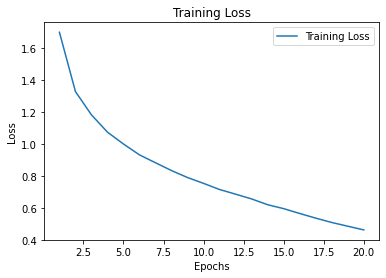

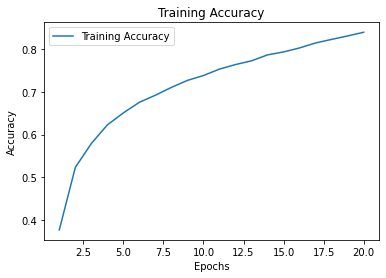

313/313 [==============================] - 1s 4ms/step - loss: 0.9040 - accuracy: 0.7209
Loss: 0.904029130935669
Accuracy: 72.08999991416931%


In [150]:
def main():
    """
    Function for testing the model
    """

    # Load the data
    trainX, trainY, testX, testY = load_data()
    model = load_model()

    # Fit the data
    history = model.fit(trainX, trainY, batch_size=BATCH_SIZE, epochs=EPOCHS)

    # Plotting the data
    show_loss(history)
    show_acc(history)

    # Test model
    modelLoss, modelAccuracy = model.evaluate(testX, testY)

    # Print the models loss and accuracy
    print(f'Loss: {modelLoss}')
    print(f'Accuracy: {modelAccuracy*100}%')

if __name__ == '__main__':
    main()